# Main code file jupyter notebook version
### Katherine Duncker
#### 3/2/2025
#### You Lab

This code can be copied to run any dataset generated in this study also utilizing files loaded in throughout this notebook.

## Import necessary packages and define device for torch

In [1]:
#import python packages
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import glob
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

#import data loading and pre-processing functions from separate .py files
from data_loading_v5 import define_metadata, import_exp_data, filter_dataframes, process_dataframes, convert_reader_data, subtract,normalize 
from plot_timecourses import plottimecourselist, plottimecoursearray, figure_layout 
from crosstalk import crosstalk, mixed_crosstalk, antibiotic_crosstalk
from dose_response_fitting import dose_response_fitting
from mechanistic_model import difeq_newest_test_2, fp_total_timecourse, sensor_fit, plot_fittings
from VAE import VAE, train, test, warmup_scheduler, get_latent_variables, count_parameters
from VAEMLP import MLP, CombinedModel, combo_train, validate

## Select which community to use and process data

In [3]:
#select which microbial community dataset to work with
community='van_dapg_nar' #list of options: 'aTc_IPTG','TTR_THS','cuma_ohc_atc','van_dapg_nar', 'antibiotic_data','atc_van', 'ttr_ths_ph'

#if using antibiotic data, indicate the plasmid and inhibitor combination
plasmid='HSGBla' #options: 'Bla', 'BlaM', 'HSGBla', 'HSGBlaM'
inhibitor='TAZ' #options: 'TAZ', 'SUL'
if community!='antibiotic_data':
    plasmid=None
    inhibitor=None

#import metadata for selected community
files,readers, fluors, fluor1, fluor2, fluor3, single_file, sensor_names, sensors,time_vector,od_raws,input_arrays,input_names,fp1_raws,fp2_raws,fp3_raws = define_metadata(community,plasmid,inhibitor)

if community=='antibiotic_data':
    od_conv=od_raws
    fp1_conv=fp1_raws
    fp2_conv=fp2_raws
    fp3_conv=None
else:
    # convert the plate reader data to match based on calibrations
    od_conv=convert_reader_data(readers, None, od_raws,community)
    fp1_conv=convert_reader_data(readers, fluor1, fp1_raws,community)
    fp2_conv=convert_reader_data(readers, fluor2, fp2_raws,community)
    if sensors==3:
        fp3_conv=convert_reader_data(readers, fluor3, fp3_raws,community)
    else:
        fp3_conv=None

# Subtract basal expression (sample with 0 inducers added) time course from all time courses of the same experiment 
subtracted_fp1_conv_all, subtracted_fp2_conv_all, subtracted_fp3_conv_all=subtract(community,time_vector,fp1_conv,fp2_conv,fp3_conv,sensors,input_arrays)

# Min-max scale each fluorescence time course to be on a scale from 0-1
normalized_fp1_conv_all, normalized_fp2_conv_all, normalized_fp3_conv_all=normalize(subtracted_fp1_conv_all,subtracted_fp2_conv_all,subtracted_fp3_conv_all)

#Append the full OD and fluorescence timecourses from the normalized dataset
#stack the OD time courses to be in the same format the fluorescence curves are
od_stack=np.empty((0,len(time_vector)), dtype=float)
for i, reader in enumerate(fluor1):
    od_stack=np.vstack((od_stack,od_conv[i]))
# Initialize the list of arrays to concatenate
concat_list = [od_stack]
#append each time course
concat_list.append(normalized_fp1_conv_all)
concat_list.append(normalized_fp2_conv_all)
if normalized_fp3_conv_all is not None and normalized_fp3_conv_all.size>0:  # Check if fp3 is None
    concat_list.append(normalized_fp3_conv_all)
exp_data_new=np.concatenate(concat_list,axis=1)
    
#concatenate all experimental input data into one array
exp_inputs=np.vstack(list(input_arrays.values())) #used to be normalized_input_arrays

### Plot data from each step of processing

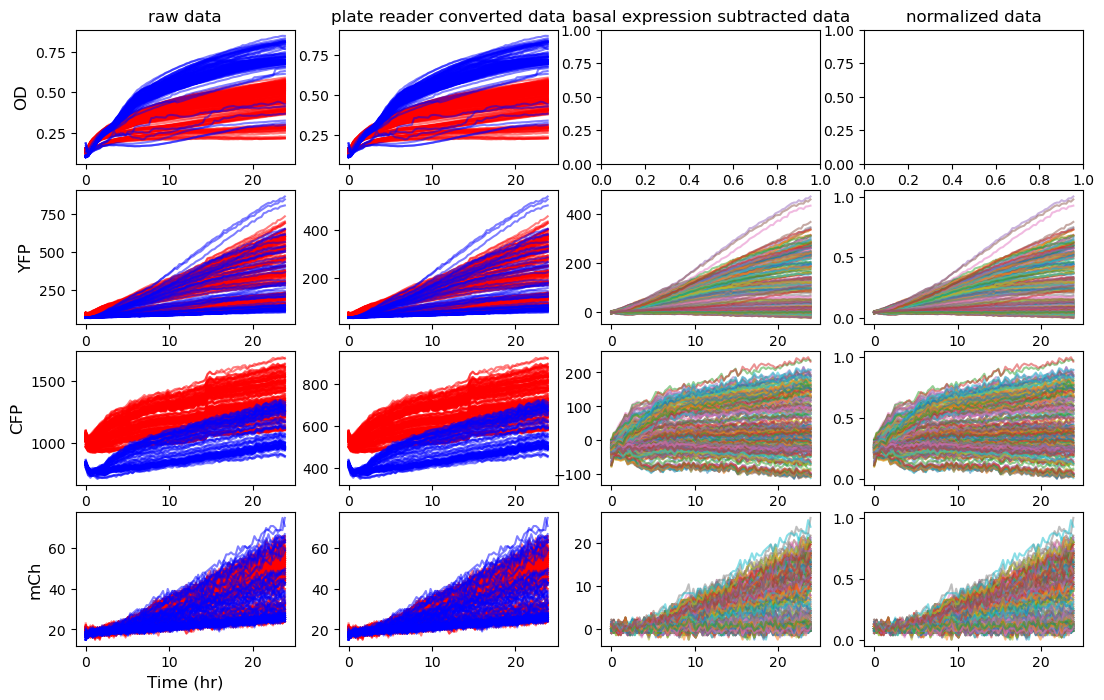

In [4]:
# Plot raw, converted, subtracted (full basal timecourse is subtracted), normalized
#Plot the time courses after each step of pre-processing
if sensors==2:
    rawlists=[od_raws,fp1_raws,fp2_raws]
    convlists=[od_conv,fp1_conv,fp2_conv]
    subtractedarrays=[subtracted_fp1_conv_all,subtracted_fp2_conv_all]
    normalizedarrays=[normalized_fp1_conv_all,normalized_fp2_conv_all]
else:
    rawlists=[od_raws,fp1_raws,fp2_raws,fp3_raws]
    convlists=[od_conv,fp1_conv,fp2_conv,fp3_raws]
    subtractedarrays=[subtracted_fp1_conv_all,subtracted_fp2_conv_all,subtracted_fp3_conv_all]
    normalizedarrays=[normalized_fp1_conv_all,normalized_fp2_conv_all,normalized_fp3_conv_all]
figure_layout(sensors,rawlists,convlists,subtractedarrays,normalizedarrays,time_vector,fluors)

#save figure
if community=='antibiotic_data':
    save_dir = f"figures/{community}/{plasmid}_{inhibitor}/"
else:
    save_dir = f"figures/{community}/"
os.makedirs(save_dir, exist_ok=True)
# plt.savefig(f'{save_dir}timecourse processing.svg',format='svg')

## Estimate mechanistic model parameters using single time point data
### Crosstalk

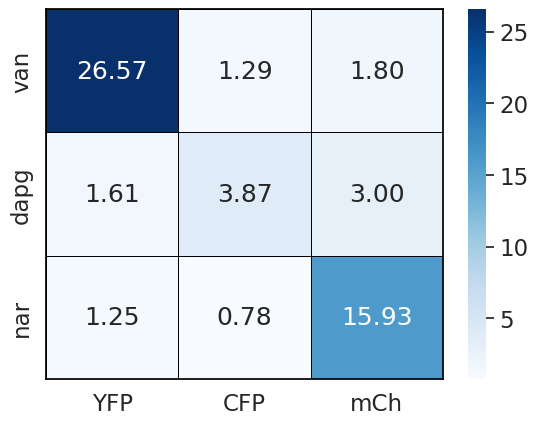

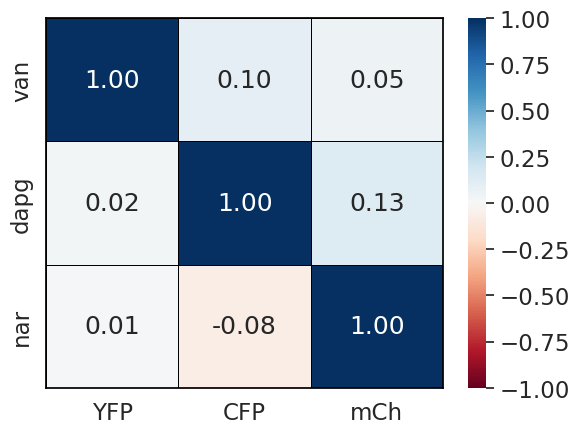

In [6]:
'''crosstalk calculation from mixed culture data'''
#Choose time point to calculate alpha from 
timepoint=20 #define desired hours of interest 

#perform function to calculate alphas and plot crosstalk heatmap
#for antibiotic sensor communities:
if community=='antibiotic_data':
    alphas,fig=antibiotic_crosstalk(timepoint,time_vector,files,od_raws,fp1_raws,fp2_raws,fluors)
    #save figure
    save_dir = f"figures/{community}/{plasmid}_{inhibitor}/"
    os.makedirs(save_dir, exist_ok=True)
    fig.savefig(f'{save_dir}mixed culture crosstalk.svg',format='svg')
else:
    #for regular sensor communities
    if ((community=='aTc_IPTG')|(community=='TTR_THS')):
        file=files[0]
    elif community=='cuma_ohc_atc':
        file=files[2]
    elif ((community=='van_dapg_nar')|(community=='atc_van')):
        file=files[1]
    alphas,fig=mixed_crosstalk(file,sensors,timepoint,fluors)
    #save figure
    save_dir = f"figures/{community}/"
    os.makedirs(save_dir, exist_ok=True)
    fig.savefig(f'{save_dir}mixed culture crosstalk.svg',format='svg')

#### save alphas

In [ ]:
#don't run this cell if we already have the alphas saved from previously
#save parameters
datestamp = datetime.now().strftime("%Y-%m-%d") # Format: YYYY-MM-DD
if community=='antibiotic_data':
    save_dir = f"parameter_files/{community}/{plasmid}_{inhibitor}/"
    os.makedirs(save_dir, exist_ok=True)
    filename= f"{save_dir}{datestamp}_{timepoint}hr_{community}_alphas_mixed.npy"
else:
    save_dir = f"parameter_files/{community}/"
    os.makedirs(save_dir, exist_ok=True)
    filename= f"{save_dir}{datestamp}_{timepoint}hr_{community}_alphas_mixed.npy"
    
np.save(filename, alphas)

### dose response hill function

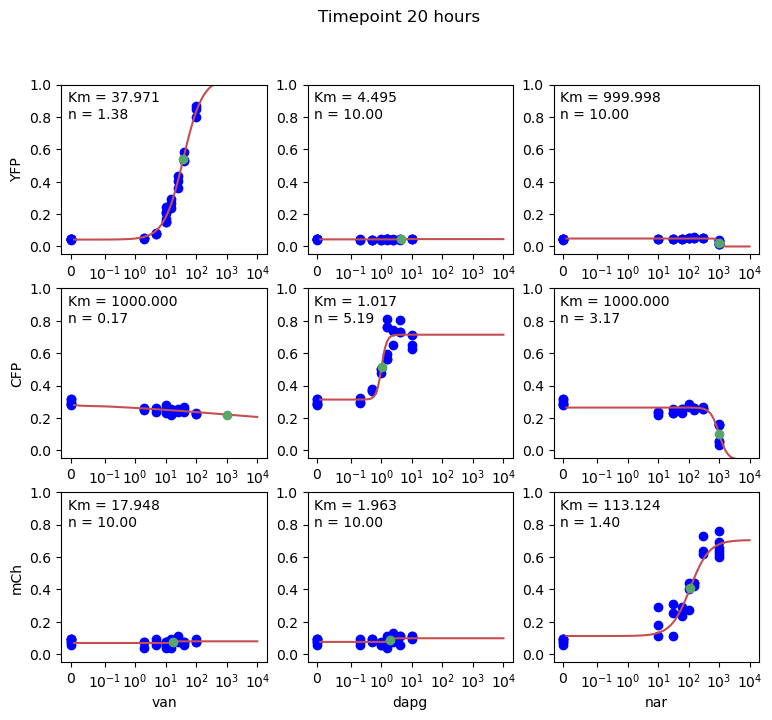

In [7]:
#Choose time point to calculate hill and K calc values from
hill_timepoint=20 #define desired hours of interest - usually 20

'''perform function to calculate alphas and plot crosstalk heatmap'''\
#if you want to change the y-axis scale, see the comment in the python code for plotting the dose responses to change scale
K_calc, hill_calc,fig=dose_response_fitting(hill_timepoint, exp_inputs, normalized_fp1_conv_all, normalized_fp2_conv_all, normalized_fp3_conv_all, time_vector, input_names, sensors, fluors,community,plasmid,inhibitor)

#save figure
if community=='antibiotic_data':
    save_dir = f"figures/{community}/{plasmid}_{inhibitor}/"
    os.makedirs(save_dir, exist_ok=True)
else:
    save_dir = f"figures/{community}/"
    os.makedirs(save_dir, exist_ok=True)
    
fig.savefig(f'{save_dir}dose response_samescale.svg',format='svg')

#### save K and n values

In [ ]:
#don't run this cell if we already have the K and n saved from previously
#save parameters
if community=='antibiotic_data':
    save_dir = f"parameter_files/{community}/{plasmid}_{inhibitor}/"
else:
    save_dir = f"parameter_files/{community}/"

os.makedirs(save_dir, exist_ok=True)
datestamp = datetime.now().strftime("%Y-%m-%d") # Format: YYYY-MM-DD
hill_filename= f"{save_dir}{datestamp}_{hill_timepoint}hr_{community}_hill_coef.npy"
K_filename= f"{save_dir}{datestamp}_{hill_timepoint}hr_{community}_K_calc.npy"
np.save(hill_filename, hill_calc)
np.save(K_filename, K_calc)

### Load parameters and process inputs

In [ ]:
'''load the calculated sensor parameter values if not calculating them this time'''#choose timepoint calculation for alpha you want to import
timepoint=20 
if community=='antibiotic_data':
    save_dir = f"parameter_files/{community}/{plasmid}_{inhibitor}/"
else:
    save_dir = f"parameter_files/{community}/"

alpha_files=glob.glob(f'{save_dir}*_{timepoint}hr_{community}_alphas_mixed.npy') # List all matching files
alphas=np.load(max(alpha_files)) #load the most recent K calc file

#choose timept calculation for hill parameters you want to import
hill_timepoint=20 

K_files=glob.glob(f'{save_dir}*_{hill_timepoint}hr_{community}_K_calc.npy') # List all matching files
K_calc=np.load(max(K_files)) #load the most recent K calc file
    
hill_files=glob.glob(f'{save_dir}*_{hill_timepoint}hr_{community}_hill_coef.npy') # List all matching files
hill_calc=np.load(max(hill_files)) #load the most recent hill calc file


'''normalize inputs and K_calc with K_calc (everything will be centered around 1 and K will be 1 for each sensor)'''

'''calculate the limit range for inputs based on K and n'''
# extract true_K = K_calc for the respective intended sensor
true_K=np.zeros(sensors) #true_K= K values in same order as input 1, input 2
upper=np.zeros(sensors)
lower=np.zeros(sensors)
for i in range(sensors):
    true_K[i]=K_calc[i*sensors + i] 
    upper[i]=true_K[i]*(99**(1/hill_calc[i*sensors + i]))
    lower[i]=true_K[i]/(99**(1/hill_calc[i*sensors + i])) 

'''Remove data where inputs are outside threshold limits''' #cut this section if it doesn't help the prediction
if ((community=='cuma_ohc_atc')|(community=='van_dapg_nar')|(community=='antibiotic_data')):
    mask=(exp_inputs>0).all(axis=1)
else:
    mask = (exp_inputs >= lower).all(axis=1) & (exp_inputs <= upper).all(axis=1) 
# Filter the arrays based on the mask
filtered_exp_inputs = exp_inputs[mask]
filtered_exp_data_new = exp_data_new[mask]

'''normalize inputs and K_calc with the K value for the intended sensor'''
# Normalize the filtered inputs array by dividing by K
normalized_exp_inputs = filtered_exp_inputs / true_K  #fgh - change filtered_exp_inputs to exp_inputs if we don't want to cut that many datapoints
normalized_K_calc=K_calc.reshape((sensors,sensors))/true_K #reshaped to make the calculation easier and needs to be reshaped for the ODEs anyway

### Fit ODEs to experimental data to estimate remaining parameters

In [ ]:
''' Only run this cell if you need to re-generate ODE parameters and respective simulated timecourses'''
all_params_test=np.zeros((1,7*sensors)) #number of experiments to iterate through by number of params optimizing

alpha=alphas.reshape((sensors,sensors))
hill=hill_calc.reshape((sensors,sensors))
all_params_test,test_cost, evals=sensor_fit(sensors,filtered_exp_data_new,time_vector,normalized_exp_inputs,alpha,normalized_K_calc,hill)
print(all_params_test)
print(test_cost)
print('# evals:',evals)

#save parameters
if community=='antibiotic_data':
    save_dir = f"parameter_files/{community}/{plasmid}_{inhibitor}/"
else:
    save_dir = f"parameter_files/{community}/"

os.makedirs(save_dir, exist_ok=True)
datestamp = datetime.now().strftime("%Y-%m-%d") # Format: YYYY-MM-DD
np.save(f'{save_dir}{datestamp}_{community}_params.npy', all_params_test)
np.save(f'{save_dir}{datestamp}_{community}_fit_cost.npy',test_cost)

#### Plot fitted simulated data with experimental data

In [ ]:
'''Load or use parameters defined above'''
# all_params_test,c=np.load(f'{community}params_full_timerange_norm_new_eq.npy')
params_files=glob.glob(f'{save_dir}*_{community}_params.npy') # List all matching files
all_params_test=np.load(max(params_files)) #load the most recent params file

fig=plot_fittings(time_vector,sensors,filtered_exp_data_new,filtered_exp_inputs,alphas,hill_calc,all_params_test,normalized_K_calc,normalized_exp_inputs,fluors,community)

#save figure
if community=='antibiotic_data':
    save_dir = f"figures/{community}/{plasmid}_{inhibitor}/"
else:
    save_dir = f"figures/{community}/"

os.makedirs(save_dir, exist_ok=True)
fig.savefig(f'{save_dir}ODE_fittings.svg',format='svg')

## Generate 10k simulations using optimized parameter set with different input conditions

In [ ]:
#calculate the average initial conditions
inits_train=filtered_exp_data_new[:,0::len(time_vector)]

#find the average initial conditions
od_0_mean=np.mean(inits_train[:,0])/sensors
od_0=inits_train[:,0]/sensors
fluor_01_mean=np.mean(inits_train[:,1]/od_0) #set initial fluor/cell
fluor_02_mean=np.mean(inits_train[:,2]/od_0) #set initial fluor/cell

#calculate the standard deviation for initial conditions
od_0_std=np.std(inits_train[:,0])/sensors
fluor_01_std=np.std(inits_train[:,1]/od_0) #set initial fluor/cell
fluor_02_std=np.std(inits_train[:,2]/od_0) #set initial fluor/cell

#calculate the max for initial conditions
od_0_max=np.max(inits_train[:,0])/sensors
fluor_01_max=np.max(inits_train[:,1]/od_0) #set initial fluor/cell
fluor_02_max=np.max(inits_train[:,2]/od_0) #set initial fluor/cell

#calculate the min for initial conditions
od_0_min=np.min(inits_train[:,0])/sensors
fluor_01_min=np.min(inits_train[:,1]/od_0) #set initial fluor/cell
fluor_02_min=np.min(inits_train[:,2]/od_0) #set initial fluor/cell

#perform the same calculations for third population
if sensors==3:
    fluor_03_mean=np.mean(inits_train[:,3]/od_0) #set initial fluor/cell 
    fluor_03_std=np.std(inits_train[:,3]/od_0) #set initial fluor/cell
    fluor_03_max=np.max(inits_train[:,3]/od_0) #set initial fluor/cell
    fluor_03_min=np.min(inits_train[:,3]/od_0) #set initial fluor/cell

In [ ]:
from scipy.integrate import odeint, solve_ivp
from scipy.stats import truncnorm

'''Load or use parameters defined above'''
if community=='antibiotic_data':
    save_dir = f"parameter_files/{community}/{plasmid}_{inhibitor}/"
else:
    save_dir = f"parameter_files/{community}/"
params_files=glob.glob(f'{save_dir}*_{community}_params.npy') # List all matching files
all_params_test=np.load(max(params_files)) #load the most recent params file

#reshape parameters
optimized_params=all_params_test.reshape(sensors,7)
alpha=alphas.reshape((sensors,sensors))
hill=hill_calc.reshape((sensors,sensors))

#define number of simulations per parameter set
num_simulations=10000

#define S conditions - assume randomly, uniformly spaced along log scale for extensive coverage of the input space
s_full = (10 ** ((np.random.rand(num_simulations, sensors) * (np.log10(upper) - np.log10(lower))) + np.log10(lower)))/true_K #ranging from lower to upper limits for each sensor calculated above

#initialize arrays to store time courses
time_courses=np.empty((num_simulations,sensors+1,len(time_vector)))

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

#store all y0 values
y0_values=[]

#simulate the time courses
for i in range(num_simulations):
    s=s_full[i]
    OD0=get_truncated_normal(mean=od_0_mean,sd=od_0_std,low=od_0_min,upp=od_0_max).rvs() #values determined from experimental data
    # Generate fluorescence values dynamically based on the number of sensors
    fluor_values = [
        get_truncated_normal(
            mean=globals()[f'fluor_0{j+1}_mean'],
            sd=globals()[f'fluor_0{j+1}_std'],
            low=globals()[f'fluor_0{j+1}_min'],
            upp=globals()[f'fluor_0{j+1}_max']
        ).rvs()
        for j in range(sensors)]
    # Construct y0: OD0 values for all populations followed by fluorescence values
    y0 = np.hstack(([OD0] * sensors, fluor_values))
    #solve ODEs
    sol=solve_ivp(difeq_newest_test_2,[time_vector[0],time_vector[-1]],y0,t_eval=time_vector,args=(optimized_params,alpha,normalized_K_calc,hill,s,sensors))
    time_courses[i]=fp_total_timecourse(sol.y,sensors,sensors)
    # save y0 to a list
    y0_values.append(y0)
    
# convert y0_values to a numpy array 
y0_values=np.array(y0_values)

#save time courses, input data, and initial conditions
#save parameters
if community=='antibiotic_data':
    save_dir = f"parameter_files/{community}/{plasmid}_{inhibitor}/"
else:
    save_dir = f"parameter_files/{community}/"
os.makedirs(save_dir, exist_ok=True)

datestamp = datetime.now().strftime("%Y-%m-%d") # Format: YYYY-MM-DD
np.savez(f'{save_dir}{datestamp}_{community}_curves10k.npz', time_courses)
np.save(f'{save_dir}{datestamp}_{community}_S_10k.npy', s_full)
np.save(f'{save_dir}{datestamp}_{community}_y0_10k.npy',y0_values)

## Run the simulated and experimental data through the VAE-MLP pipeline

We'll build a VAE+MLP to do input concentration estimation.
We first train a VAE using simulated data only (this will be modified later to be trained on all data) to recostruct the timecourses.
Then we using the trained VAE to train a combo VAE-MLP (where only the MLP model is updating in the training) to predict the input concentrations from timecourses.

For each iteration right now we are only using one simulated parameter set at a time from data_concat (0,1,2,3) which correspond to two experiments 0&1 correspond to march experiments and 2&3 correspond to June experiments.

Data preparation and sanity check.
1. Load simulated data
2. Each sample (corresponding to one input combination) consists of time courses under 4 parameter combinations.
3. Concatenate the time series of the measurements in each sample to generate a single time series.
4. Generate 10 plot, each showing one time series (concatenated od, fp1, fp2)

In [ ]:
'''Load simulated outputs and inputs defined above'''
# Load simulated data
curves_files=glob.glob(f'{save_dir}*_{community}_curves10k.npz') # List all matching files
#load the most recent timecourses file
data_array=np.load(max(curves_files))['arr_0'] #the 'arr_0' retrieves the array information by choosing the default array name #load the most recent params file

S_files=glob.glob(f'{save_dir}*_{community}_S_10k.npy') # List all matching files
inputs=np.load(max(S_files)) #load the most recent inputs file

#append the timecourses for each sample together to go from (10000,3, time) to (10000, 3*time) - flatten the array to be 2D
data_concat = data_array.reshape(data_array.shape[0], -1)

# prepare the data(time series).
#data_np = data_concat[:,0,:] #numpy array of the simulated datset
seq_length = data_concat.shape[1]

#combine experimental and simulated data
combined_data_np=np.vstack((data_concat,filtered_exp_data_new)) #numpy array of combined dataset

#create indices to locate the experimental data
exp_data_indices = range(data_concat.shape[0], data_concat.shape[0] + filtered_exp_data_new.shape[0])

#normalize full data
scaler = MinMaxScaler()
data_normalized_np = scaler.fit_transform(combined_data_np)
# Convert data into tensor
data_normalized = torch.tensor(data_normalized_np).float()
 # Add an extra dimension for the 1D CNN (batch_size, num_channels, seq_length)
data_normalized = data_normalized.unsqueeze(1)

#prepare experimental data for testing
#scale exp_data
exp_data_normalized = scaler.transform(filtered_exp_data_new)
# Convert data into tensor
exp_data_normalized = torch.tensor(exp_data_normalized).float()
 # Add an extra dimension for the 1D CNN (batch_size, num_channels, seq_length)
exp_data_normalized = exp_data_normalized.unsqueeze(1)

import time as timer
# Determine device (enables GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
print(device)

t0=timer.perf_counter()

# Hyperparameters
batch_size = 32
latent_dim = 10
latent_channel=6
alpha = 1e-4 #coefficient in the trianing which balances the importance of reconstruction loss and KL divergence (5e-4 for old bla model)
lr= 1e-3 #learning rate for the optimizer (1e-3 for combo model)
min_lr = 5e-6 #(1e-7 for Lingchong's model)
epochs = 400 #(1000 for Lingchong's model)
gamma = 0.99 #(0.98 for Lingchong's model)
weight_decay=1e-5

# Split the data into train and test sets
train_data, test_data, train_indices, test_indices = train_test_split(data_normalized, range(data_normalized.shape[0]), test_size=0.2, random_state=42) #fix min-max

train_data = train_data.clone().detach().float()
test_data = test_data.clone().detach().float()

# Prepare DataLoader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Model creation, loss function, and optimizer
#set a random seed for VAE training - may need to change the seed value if the training keeps failing
torch.manual_seed(42)
model = VAE(latent_dim=latent_dim,latent_channel=latent_channel,seq_length=seq_length)
model = model.to(device)
print(f'The model has {count_parameters(model):,} parameters')
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr= lr, weight_decay=weight_decay)

# Training loop
train_loss_values = []
test_loss_values = []

# Initialize early stopping parameters
best_test_loss = np.inf  # Best test loss so far
epochs_no_improve = 0  # Counter for epochs since the test loss last improved
patience = 30 # Patience for early stopping

# implements a warmup schedule to start from a small learn rate.
warmup_epochs = 8

scheduler1 = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: warmup_scheduler(epoch, warmup_epochs))
scheduler2 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, criterion, alpha,device,latent_channel,seq_length)
    test_loss = test(model, test_loader, criterion,device,latent_channel,seq_length)
    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)

    # Clamp minimum learning rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = max(param_group['lr'], min_lr)

    interval = 2 if epoch < 10 else 40
    if (epoch + 1) % interval == 0:
        print('Epoch: {} Train: {:.7f}, Test: {:.7f}, Lr:{:.8f}'.format(epoch + 1, train_loss_values[epoch], test_loss_values[epoch], param_group['lr']))
        t1=timer.perf_counter()
        print('time=%i s'%(t1-t0))
    # Update learning rate
    if epoch < warmup_epochs:
        scheduler1.step()
    else:
        scheduler2.step()

    # Check for early stopping
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        epochs_no_improve = 0  # Reset the counter
    else:
        epochs_no_improve += 1  # Increment the counter

    if epochs_no_improve == patience:
        print('Early stopping!')
        break  # Exit the loop

# After training, get the latent variables
train_latent_vars = get_latent_variables(model, train_loader,device,latent_channel,seq_length)
test_latent_vars = get_latent_variables(model, test_loader,device,latent_channel,seq_length)


In [ ]:
'''
Store and save latent variables that correspond to training/test data order and save the trained VAE model
'''

import os

combined_indices = np.concatenate([train_indices, test_indices])
combined_latent_vars = np.concatenate([train_latent_vars, test_latent_vars])

# Get the order of samples in the original dataset
sort_indices = np.argsort(combined_indices)

# Sort combined_latent_vars in the original order
combined_latent_vars = combined_latent_vars[sort_indices]

# Save the state dictionary of the encoder
datestamp = datetime.now().strftime("%Y-%m-%d") # Format: YYYY-MM-DD
if community=='antibiotic_data':
    save_dir = f"final_trained_models/{community}/{plasmid}_{inhibitor}/"
else:
    save_dir = f"final_trained_models/{community}/"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, f"{datestamp}_VAE_{community}.pt")
torch.save(model.state_dict(), model_path)

# Store the combined data (training and testing latent variables) to a file
np.save(f"{save_dir}{datestamp}_latent_variables_{community}.npy", combined_latent_vars)
#store the training, testing, and experimental data indices to a file for later
np.save(f'{save_dir}{datestamp}_train_indices_{community}.npy',train_indices)
np.save(f'{save_dir}{datestamp}_test_indices_{community}.npy',test_indices)
np.save(f'{save_dir}{datestamp}_exp_data_indices_{community}.npy',exp_data_indices)



In [ ]:
# load training and testing indices
if community=='antibiotic_data':
    save_dir = f"final_trained_models/{community}/{plasmid}_{inhibitor}/"
else:
    save_dir = f"final_trained_models/{community}/"
train_ind_files=glob.glob(f'{save_dir}*_train_indices_{community}.npy') #list all matching train indices files
#load the most recent train indices file
train_indices=np.load(max(train_ind_files))
test_ind_files=glob.glob(f'{save_dir}*_test_indices_{community}.npy') #list all matching train indices files
#load the most recent test indices file
test_indices=np.load(max(test_ind_files))

# DataLoader
train_data = data_normalized[train_indices].clone().detach().float()
# train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_data = data_normalized[test_indices].clone().detach().float()
# test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
#save figure
if community=='antibiotic_data':
    save_dir = f"figures/{community}/{plasmid}_{inhibitor}/"
else:
    save_dir = f"figures/{community}/"
os.makedirs(save_dir, exist_ok=True)

# # Plotting the loss values
plt.figure(figsize=(6, 3))
plt.semilogy(train_loss_values, label='Training')
plt.semilogy(test_loss_values, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.gcf().savefig(f'{save_dir}VAE_loss.svg',format='svg')
plt.show()
plt.close()

# Percentage of data to retrieve
percentage = 1

# Calculate the number of samples to retrieve
num_train_samples = int(len(train_data) * percentage)
num_test_samples = int(len(test_data) * percentage)

# Index into the data tensors
subset_train_data = train_data[:num_train_samples].to(device)
subset_test_data = test_data[:num_test_samples].to(device)

with torch.no_grad():
    output_train, _, _ = model(subset_train_data,latent_channel,seq_length)
    output_test, _, _ = model(subset_test_data,latent_channel,seq_length)


# Squeeze the output to match the original data dimension
output_train = output_train.squeeze(1)
output_test = output_test.squeeze(1)

##fix min-max
# Scale the reconstructed data back to the range of the original data
output_train = scaler.inverse_transform(output_train.cpu().numpy())
output_test = scaler.inverse_transform(output_test.cpu().numpy())
# Scale the original data back to the original range
subset_train_data = scaler.inverse_transform(subset_train_data.cpu().numpy().squeeze(1))
subset_test_data = scaler.inverse_transform(subset_test_data.cpu().numpy().squeeze(1))

# Plotting the reconstructed data against the original data
fig, axs = plt.subplots(1, 2, figsize=(6, 3))

# Training data plot
axs[0].scatter(subset_train_data.flatten(), output_train.flatten(), s=0.1, color='blue', alpha=0.5)
axs[0].plot([np.min(subset_train_data), np.max(subset_train_data)], [np.min(subset_train_data), np.max(subset_train_data)], 'r')  # y=x line
axs[0].set_xlim(np.min(subset_train_data), np.max(subset_train_data))
axs[0].set_ylim(np.min(subset_train_data), np.max(subset_train_data))
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_xlabel('Original Data')
axs[0].set_ylabel('Reconstructed Data')
axs[0].set_title('Training Data')
r2_train = r2_score(subset_train_data.flatten(), output_train.flatten())
axs[0].text(0.05, 0.95, f'R^2 = {r2_train:.3f}', transform=axs[0].transAxes, verticalalignment='top')

# Testing data plot
axs[1].scatter(subset_test_data.flatten(), output_test.flatten(), s=0.1, color='blue', alpha=0.5)
axs[1].plot([np.min(subset_test_data), np.max(subset_test_data)], [np.min(subset_test_data), np.max(subset_test_data)], 'r')  # y=x line
axs[1].set_xlim(np.min(subset_test_data), np.max(subset_test_data))
axs[1].set_ylim(np.min(subset_test_data), np.max(subset_test_data))
axs[1].set_aspect('equal', adjustable='box')
axs[1].set_xlabel('Original Data')
axs[1].set_ylabel('Reconstructed Data')
axs[1].set_title('Testing Data')
r2_test = r2_score(subset_test_data.flatten(), output_test.flatten())
axs[1].text(0.05, 0.95, f'R^2 = {r2_test:.3f}', transform=axs[1].transAxes, verticalalignment='top')

plt.tight_layout()
#save figure: has to be png for this figure because there are too many points to render a svg
fig.savefig(f'{save_dir}VAE_augmented_r2.png',format='png',dpi=300)

plt.show()

# Additional Panels for Sample Data Trajectories
fig, axs = plt.subplots(2, 5, figsize=(10, 3))

# Training data trajectories
for i in range(5):
    axs[0, i].plot(subset_train_data[i], label='Original', color='blue')
    axs[0, i].plot(output_train[i], label='Reconstructed', color='orange')
    axs[0, i].set_title(f'Training {i + 1}')
#    axs[0, i].legend()

# Testing data trajectories
for i in range(5):
    axs[1, i].plot(subset_test_data[i], label='Original', color='blue')
    axs[1, i].plot(output_test[i], label='Reconstructed', color='orange')
    axs[1, i].set_title(f'Testing {i + 1}')
#    axs[1, i].legend()

plt.tight_layout()
fig.savefig(f'{save_dir}VAE_augmented_reconstructions.svg',format='svg')
plt.show()


In [ ]:
#plot the experimental reconstruction with the VAE of the full timecourses

# Create masks for identifying indices belonging to filtered_exp_data_new
train_mask = np.isin(train_indices, exp_data_indices)
test_mask = np.isin(test_indices, exp_data_indices)

# Extract the relevant parts using the masks
train_filtered_data = train_data[train_mask]
test_filtered_data = test_data[test_mask]

with torch.no_grad():
    output_train, _, _ = model(train_filtered_data.to(device),latent_channel,seq_length)
    output_test, _, _ = model(test_filtered_data.to(device),latent_channel,seq_length)

# Squeeze the output to match the original data dimension
output_train = output_train.squeeze(1)
output_test = output_test.squeeze(1)

# Scale the reconstructed data back to the range of the original data
#output_train = output_train.cpu().numpy()

# Scale the reconstructed data back to the range of the original data
output_train = scaler.inverse_transform(output_train.cpu().numpy())
output_test = scaler.inverse_transform(output_test.cpu().numpy())
# Scale the original data back to the original range
subset_train_data = scaler.inverse_transform(train_filtered_data.cpu().numpy().squeeze(1)) 
subset_test_data = scaler.inverse_transform(test_filtered_data.cpu().numpy().squeeze(1)) 

# Plotting the reconstructed data against the original data
fig, axs = plt.subplots(1, 2, figsize=(6, 3))

# Training data plot
axs[0].scatter(subset_train_data.flatten(), output_train.flatten(), s=0.1, color='blue', alpha=0.5)
axs[0].plot([np.min(subset_train_data), np.max(subset_train_data)], [np.min(subset_train_data), np.max(subset_train_data)], 'r')  # y=x line
axs[0].set_xlim(np.min(subset_train_data), np.max(subset_train_data))
axs[0].set_ylim(np.min(subset_train_data), np.max(subset_train_data))
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_xlabel('Original Data')
axs[0].set_ylabel('Reconstructed Data')
axs[0].set_title('Experimental Train Data')
r2_train = r2_score(subset_train_data.flatten(), output_train.flatten())
axs[0].text(0.05, 0.95, f'R^2 = {r2_train:.3f}', transform=axs[0].transAxes, verticalalignment='top')

# Testing data plot
axs[1].scatter(subset_test_data.flatten(), output_test.flatten(), s=0.1, color='blue', alpha=0.5)
axs[1].plot([np.min(subset_test_data), np.max(subset_test_data)], [np.min(subset_test_data), np.max(subset_test_data)], 'r')  # y=x line
axs[1].set_xlim(np.min(subset_test_data), np.max(subset_test_data))
axs[1].set_ylim(np.min(subset_test_data), np.max(subset_test_data))
axs[1].set_aspect('equal', adjustable='box')
axs[1].set_xlabel('Original Data')
axs[1].set_ylabel('Reconstructed Data')
axs[1].set_title('Experimental Validation Data')
r2_test = r2_score(subset_test_data.flatten(), output_test.flatten())
axs[1].text(0.05, 0.95, f'R^2 = {r2_test:.3f}', transform=axs[1].transAxes, verticalalignment='top')

plt.tight_layout()
fig.savefig(f'{save_dir}VAE_experimental_r2.png',format='png',dpi=300)

plt.show()

# Additional Panels for Sample Data Trajectories
fig, axs = plt.subplots(2, 5, figsize=(10, 3))

# Training data trajectories
for i in range(5):
    axs[0, i].plot(subset_train_data[i], label='Original', color='blue')
    axs[0, i].plot(output_train[i], label='Reconstructed', color='orange')
    axs[0, i].set_title(f'Exp train{i + 1}')
#    axs[0, i].legend()

# Testing data trajectories
for jj in range(5):
    i=jj+5
    axs[1, jj].plot(subset_test_data[i], label='Original', color='blue')
    axs[1, jj].plot(output_test[i], label='Reconstructed', color='orange')
    axs[1, jj].set_title(f'Exp test{i + 1}')
#    axs[1, i].legend()

plt.tight_layout()
fig.savefig(f'{save_dir}VAE_experimental_reconstructions.svg',format='svg')
plt.show()


## Combined VAE-MLP code
### training/testing the MLP part on simulated data
The following code:
1. Load a pre-trained VAE model with latent dimension of 10. It is important to make sure the architecture of the pre-trained VAE is identical to what's defined in this code.
2. Create a new model by combining the encoder of the VAE model and an MLP model to map the latent variables to parameters.
3. Train the combined model by using the time courses of n to predict the corresponding parameter values.
4. During the training, the pre-trained model encoder is frozen. That is, the NN parameters associated with the encoder are not further adjusted. Instead, only the MLP parameters are updated.
5. Upon training, the combined model can then allow the estimation of ODE parameters from the n time courses.

During training, learn rate decays exponentially by a rate of 'gamma'. The training also implements weight decay to penalize large weights.
In addition, the training is stopped if test loss does not decrease in 30 consecutive epochs

In [ ]:
'''Process data for combining both simulated and experimental data prior to training MLP'''

combined_inputs=np.vstack((inputs,normalized_exp_inputs))

log_inputs=np.log10(combined_inputs)

#convert inputs to tensor
log_inputs=torch.from_numpy(log_inputs).float().to(device) #used as the input into the model to train on


#prepare experimental data for testing
log_exp_inputs=np.log10(normalized_exp_inputs) #natural log
# Convert inputs to torch tensor
exp_inputs_tensor = torch.from_numpy(log_exp_inputs).float().to(device)

'''create variables and hyperparameters for VAE-MLP'''
#MLP input and output size
input_size = data_normalized.shape[1] 
output_size = log_inputs.shape[1]

# VAE Hyperparameters - redefine for combo model - make sure they are the same as those used to train the VAE model being used
batch_size = 32
latent_dim = 10      #call latent dimension size for VAE 
latent_channel=6     #call latent channel size for vae
lr= 1e-3 #learning rate for the optimizer (1e-3 for combo model)
min_lr = 5e-6 #(1e-7 for Lingchong's model)
epochs = 400 #(1000 for Lingchong's model)
gamma = 0.99 #(0.98 for Lingchong's model)
weight_decay=1e-5

#MLP hyperparameter
hidden_size = 128    #width of MLP hidden layers


In [ ]:
''' train MLP on experimental and simulated data - this is the version trained on combined_inputs'''

# load training and testing indices
if community=='antibiotic_data':
    save_dir = f"final_trained_models/{community}/{plasmid}_{inhibitor}/"
else:
    save_dir = f"final_trained_models/{community}/"
train_ind_files=glob.glob(f'{save_dir}*_train_indices_{community}.npy') #list all matching train indices files
#load the most recent train indices file
train_indices=np.load(max(train_ind_files))
test_ind_files=glob.glob(f'{save_dir}*_test_indices_{community}.npy') #list all matching train indices files
#load the most recent test indices file
test_indices=np.load(max(test_ind_files))

# generate train and test dataset
X_train=data_normalized[train_indices]
X_test = data_normalized[test_indices]
y_train = log_inputs[train_indices]
y_test = log_inputs[test_indices]

# Create an instance of the MLP model
mlp_model = MLP(latent_dim, hidden_size, output_size).to(device)
# Create an instance of the VAE model
vae_model = VAE(latent_dim,latent_channel,seq_length).to(device)

# Load the trained VAE model. Trained above.
VAE_files=glob.glob(f'{save_dir}*_VAE_{community}.pt') #list all matching VAE files
#load the most recent VAE model file
vae_model.load_state_dict(torch.load(max(VAE_files)))

# Create an instance of the combined model
'''This is where you will change the number of the model name for each iteration in case you want to plot an old model without having to train it again'''
combined_model_combo2 = CombinedModel(vae_model, mlp_model).to(device)

#print number of parameters for the combined VAE-MLP model
print(f'The mlp model has {count_parameters(mlp_model):,} parameters')
print(f'The combined model has {count_parameters(combined_model_combo2):,} parameters')

# Loss function and optimizer for training the MLP model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=lr, weight_decay=weight_decay)

# Train the MLP model
mlp_model.train()

# Initialize early stopping parameters
best_test_loss = np.inf  # Best test loss so far
epochs_no_improve = 0  # Counter for epochs since the test loss last improved
patience = 30  # Patience for early stopping

# DataLoader
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

t0=timer.perf_counter()

# implements a warmup schedule to start from a small learn rate.
warmup_epochs = 8

scheduler1 = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: warmup_scheduler(epoch, warmup_epochs))
scheduler2 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

# Training loop
train_loss_values = []
test_loss_values = []

for epoch in range(epochs):
    train_loss = combo_train(combined_model_combo2, train_loader, optimizer, criterion,device,latent_channel,seq_length)
    test_loss = validate(combined_model_combo2, test_loader, criterion,device,latent_channel,seq_length)
    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)

    # Clamp minimum learning rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = max(param_group['lr'], min_lr)

    interval = 2 if epoch <10 else 40
    if (epoch+1) % interval == 0:
        print('Epoch: {} Train: {:.7f}, Test: {:.7f}, Lr:{:.8f}'.format(epoch + 1, train_loss, test_loss, param_group['lr']))
        t1=timer.perf_counter()
        print('time=%i s'%(t1-t0))
    # Update learning rate
    if epoch < warmup_epochs:
        scheduler1.step()
    else:
        scheduler2.step()

    # Check for early stopping
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        epochs_no_improve = 0  # Reset the counter
    else:
        epochs_no_improve += 1  # Increment the counter

    if epochs_no_improve == patience:
        print('Early stopping!')
        break  # Exit the loop

In [ ]:
'''
Store and save trained MLP model
'''
import os

# Save the state dictionary of the combined VAE-MLP
datestamp = datetime.now().strftime("%Y-%m-%d") # Format: YYYY-MM-DD
if community=='antibiotic_data':
    save_dir = f"final_trained_models/{community}/{plasmid}_{inhibitor}/"
else:
    save_dir = f"final_trained_models/{community}/"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, f"{datestamp}_VAEMLP_{community}.pt")

torch.save(combined_model_combo2.state_dict(), model_path)

1. Plot training and testing losses as the function of epochs
2. Plot the reconstructed input concentrations against the true input concentrations for each input individually. Show R^2 scores.
3. The 2 inputs are:
input_names 

In [ ]:
'''
Load the previously trained VAE-MLP model
'''
# Create an instance of the VAE model
vae_model = VAE(latent_dim,latent_channel,seq_length).to(device)
# Create an instance of the MLP model
mlp_model = MLP(latent_dim, hidden_size, output_size).to(device)

# Create an instance of the combined model
combined_model_combo2 = CombinedModel(vae_model, mlp_model).to(device)

if community=='antibiotic_data':
    save_dir = f"final_trained_models/{community}/{plasmid}_{inhibitor}/"
else:
    save_dir= f'final_trained_models/{community}/'
MLP_files=glob.glob(f'{save_dir}*_VAEMLP_{community}.pt') #list all matching VAE files
#load the most recent VAE model file
combined_model_combo2.load_state_dict(torch.load(max(MLP_files)))


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

if community=='antibiotic_data':
    save_dir = f"final_trained_models/{community}/{plasmid}_{inhibitor}/"
else:
    save_dir = f"final_trained_models/{community}/"
os.makedirs(save_dir, exist_ok=True)

# Plotting the loss values
plt.figure(figsize=(4, 2))
plt.semilogy(train_loss_values, label='Training')
plt.semilogy(test_loss_values, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Percentage of data to retrieve
# For this data size, looking at all data is exhausting the memory of the cluster node.
#
percentage = 1

# Calculate the number of samples to retrieve
num_train_samples = int(len(train_data) * percentage)
num_test_samples = int(len(test_data) * percentage)

# Get the tensor data without labels
subset_train_input = train_data[:num_train_samples][0]
subset_test_input = test_data[:num_test_samples][0]

with torch.no_grad():
    output_train = combined_model_combo2(subset_train_input.to(device),latent_channel,seq_length)
    output_test = combined_model_combo2(subset_test_input.to(device),latent_channel,seq_length)


# Squeeze the output to match the original data dimension
output_train = output_train.squeeze(1)
output_test = output_test.squeeze(1)

# Scale the reconstructed data back to the range of the original data
subset_train_data = ((train_data[:num_train_samples][1].cpu().numpy()))#denormalize_parameters(train_data[:num_train_samples][1].cpu().numpy(), input_scale)
subset_test_data = ((test_data[:num_test_samples][1].cpu().numpy())) #denormalize_parameters(test_data[:num_test_samples][1].cpu().numpy(), input_scale)
output_train = ((output_train.cpu().numpy()))#denormalize_parameters(output_train.cpu().numpy(), input_scale)
output_test = ((output_test.cpu().numpy()))#denormalize_parameters(output_test.cpu().numpy(), input_scale)

# Loop over the columns
for col in range(output_train.shape[1]):
    # Create a new figure for each column
    fig, axs = plt.subplots(1, 2, figsize=(4, 2))

    # Training data plot
    axs[0].scatter(subset_train_data[:, col], output_train[:, col], s=0.2, color='blue', alpha=0.5)
    axs[0].plot([np.min(subset_train_data[:, col]), np.max(subset_train_data[:, col])], [np.min(subset_train_data[:, col]), np.max(subset_train_data[:, col])], 'r')  # y=x line
    #axs[0].set_xscale('symlog',linthresh=1e-3)
    #axs[0].set_yscale('symlog',linthresh=1e-3)
    axs[0].set_xlim(np.min(subset_train_data[:, col])-0.1, np.max(subset_train_data[:, col])+0.1)
    axs[0].set_ylim(np.min(subset_train_data[:, col])-0.1, np.max(subset_train_data[:, col])+0.1)
    axs[0].set_aspect('equal', adjustable='box')
    axs[0].set_xlabel('log(S) Original')
    axs[0].set_ylabel('log(S) Reconstructed')
    axs[0].set_title(f'Train:'+ input_names[col])
    r2_train = r2_score(subset_train_data[:, col], output_train[:, col])
    axs[0].text(0.05, 0.95, f'R^2 = {r2_train:.3f}', transform=axs[0].transAxes, verticalalignment='top')

    # Testing data plot
    axs[1].scatter(subset_test_data[:, col], output_test[:, col], s=0.2, color='blue', alpha=0.5)
    axs[1].plot([np.min(subset_test_data[:, col]), np.max(subset_test_data[:, col])], [np.min(subset_test_data[:, col]), np.max(subset_test_data[:, col])], 'r')  # y=x line

    axs[1].set_xlim(np.min(subset_test_data[:, col])-0.1, np.max(subset_test_data[:, col])+0.1)
    axs[1].set_ylim(np.min(subset_test_data[:, col]-0.1), np.max(subset_test_data[:, col])+0.1)
    axs[1].set_aspect('equal', adjustable='box')
    axs[1].set_xlabel('log(S) Original')
    axs[1].set_ylabel('log(S) Reconstructed')
    axs[1].set_title(f'Test:'+ input_names[col])
    r2_test = r2_score(subset_test_data[:, col], output_test[:, col])
    axs[1].text(0.05, 0.95, f'R^2 = {r2_test:.3f}', transform=axs[1].transAxes, verticalalignment='top')

    # plt.tight_layout()
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


if community=='antibiotic_data':
    save_dir = f"figures/{community}/{plasmid}_{inhibitor}/"
else:
    save_dir = f"figures/{community}/"
os.makedirs(save_dir, exist_ok=True)

# Plotting the loss values
plt.figure(figsize=(4, 2))
plt.semilogy(train_loss_values, label='Training')
plt.semilogy(test_loss_values, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.gcf().savefig(f'{save_dir}VAE_loss.svg',format='svg')

plt.show()

# Percentage of data to retrieve
# For this data size, looking at all data can exhaust the memory of the cluster node, so you may want to only select a portion of it.
#
percentage = 1

# Calculate the number of samples to retrieve
num_train_samples = int(len(train_data) * percentage)
num_test_samples = int(len(test_data) * percentage)

# Get the tensor data without labels
subset_train_input = train_data[:num_train_samples][0]
subset_test_input = test_data[:num_test_samples][0]

with torch.no_grad():
    output_train = combined_model_combo2(subset_train_input.to(device),latent_channel,seq_length)
    output_test = combined_model_combo2(subset_test_input.to(device),latent_channel,seq_length)


# Squeeze the output to match the original data dimension
output_train = output_train.squeeze(1)
output_test = output_test.squeeze(1)

# Scale the reconstructed data back to the range of the original data
subset_train_data = (np.log10(true_K*10**(train_data[:num_train_samples][1].cpu().numpy())))#denormalize_parameters(train_data[:num_train_samples][1].cpu().numpy(), input_scale)
subset_test_data = (np.log10(true_K*10**(test_data[:num_test_samples][1].cpu().numpy()))) #denormalize_parameters(test_data[:num_test_samples][1].cpu().numpy(), input_scale)
output_train = (np.log10(true_K*10**(output_train.cpu().numpy())))#denormalize_parameters(output_train.cpu().numpy(), input_scale)
output_test = (np.log10(true_K*10**(output_test.cpu().numpy())))#denormalize_parameters(output_test.cpu().numpy(), input_scale)

# Custom function to round to the nearest 0.5
def round_to_nearest_half(value):
    return round(value * 2) / 2

# Loop over the columns
for col in range(output_train.shape[1]):
    # Create a new figure for each column
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    # Training data plot
    axs[0].plot([np.min(subset_train_data[:, col]), np.max(subset_train_data[:, col])], [np.min(subset_train_data[:, col]), np.max(subset_train_data[:, col])], color='red',lw=3)  # y=x line
    axs[0].scatter(subset_train_data[:, col], output_train[:, col], s=30, color='blue', alpha=0.5)
    axs[0].set_xlim(np.min(subset_train_data[:, col])-0.1, np.max(subset_train_data[:, col])+0.1)
    axs[0].set_ylim(np.min(subset_train_data[:, col])-0.1, np.max(subset_train_data[:, col])+0.1)
    axs[0].set_aspect('equal', adjustable='box')
    axs[0].set_xlabel(f'True log(' +input_names[col]+')')
    axs[0].set_ylabel(f'Predicted log(' +input_names[col]+')')


    ticks=[round_to_nearest_half(np.min(subset_train_data[:, col])),round_to_nearest_half(np.median(subset_train_data[:, col])),round_to_nearest_half(np.max(subset_train_data[:, col]))]
    #axs[0].set_xticks(ticks)
    #axs[0].set_xticklabels([])
    #axs[0].set_yticks(ticks)
    #axs[0].set_yticklabels([])
    axs[0].set_title('Training')
    axs[0].tick_params(axis='both', length=10, width=2)  # Increase length and width of ticks
    r2_train = r2_score(subset_train_data[:, col], output_train[:, col])
    axs[0].text(0.05, 0.95, f'R^2 = {r2_train:.4f}', transform=axs[0].transAxes, verticalalignment='top')
    # Make borders thicker
    for spine in axs[0].spines.values():
        spine.set_linewidth(2)  # Set the border thickness

    # Testing data plot
    axs[1].plot([np.min(subset_test_data[:, col]), np.max(subset_test_data[:, col])], [np.min(subset_test_data[:, col]), np.max(subset_test_data[:, col])], color='red',lw=3)  # y=x line
    axs[1].scatter(subset_test_data[:, col], output_test[:, col], s=30, color='blue', alpha=0.5)
    #axs[1].set_xticks(ticks)
    #axs[1].set_xticklabels([])
    #axs[1].set_yticks(ticks)
    #axs[1].set_yticklabels([])
    axs[1].tick_params(axis='both', length=10, width=2)  # Increase length and width of ticks
    axs[1].set_xlim(np.min(subset_test_data[:, col])-0.1, np.max(subset_test_data[:, col])+0.1)
    axs[1].set_ylim(np.min(subset_test_data[:, col])-0.1, np.max(subset_test_data[:, col])+0.1)
    axs[1].set_aspect('equal', adjustable='box')
    #axs[1].set_xlabel('log(S) Original')
    #axs[1].set_ylabel('log(S) Reconstructed')
    axs[1].set_title('Validation')
    r2_test = r2_score(subset_test_data[:, col], output_test[:, col])
    axs[1].text(0.05, 0.95, f'R^2 = {r2_test:.3f}', transform=axs[1].transAxes, verticalalignment='top')
    # Make borders thicker
    for spine in axs[1].spines.values():
        spine.set_linewidth(2)  # Set the border thickness

    plt.tight_layout()
    fig.savefig(f'{save_dir}MLP_augmented_{input_names[col]}.svg',format='svg')
    plt.show()


In [ ]:
# Create masks for identifying indices belonging to filtered_exp_data_new
train_mask = np.isin(train_indices, exp_data_indices)
test_mask = np.isin(test_indices, exp_data_indices)

mlp_train_exp_curves=X_train[train_mask]
mlp_test_exp_curves=X_test[test_mask]
train_exp_inputs=y_train[train_mask]
test_exp_inputs=y_test[test_mask]

In [ ]:
'''Plot experimental data on pre-trained vae-mlp'''
def round_to_nearest_half(value):
    return round(value * 2) / 2
    
with torch.no_grad():
    output_exp_train = combined_model_combo2(mlp_train_exp_curves.to(device),latent_channel,seq_length)
    output_exp_test = combined_model_combo2(mlp_test_exp_curves.to(device),latent_channel,seq_length)

# Squeeze the output to match the original data dimension
output_exp_train = output_exp_train.squeeze(1)
output_exp_test = output_exp_test.squeeze(1)

# Scale the reconstructed data back to the range of the original data
subset_train_data = (np.log10(true_K*10**(train_exp_inputs.cpu().numpy())))#denormalize_parameters(train_data[:num_train_samples][1].cpu().numpy(), input_scale)
subset_test_data = (np.log10(true_K*10**(test_exp_inputs.cpu().numpy()))) #denormalize_parameters(test_data[:num_test_samples][1].cpu().numpy(), input_scale)
output_train = (np.log10(true_K*10**(output_exp_train.cpu().numpy())))#denormalize_parameters(output_train.cpu().numpy(), input_scale)
output_test = (np.log10(true_K*10**(output_exp_test.cpu().numpy())))#denormalize_parameters(output_test.cpu().numpy(), input_scale)

# Loop over the columns
for col in range(output_train.shape[1]):
    # Calculate the min and max values
    min_val = np.min([np.min(subset_train_data[:, col]),np.min(subset_test_data[:, col]),np.min(output_train[:, col]),np.min(output_test[:, col])])
    max_val = np.max([np.max(subset_train_data[:, col]),np.max(subset_test_data[:, col]),np.max(output_train[:, col]),np.max(output_test[:, col])])
    ticks=[round_to_nearest_half(min_val),round_to_nearest_half((min_val + max_val) / 2),round_to_nearest_half(max_val)]
    min_val_w_ticks=np.min([min_val,np.min(ticks)])
    max_val_w_ticks=np.max([max_val,np.max(ticks)])
    # Calculate the range
    data_range = max_val_w_ticks - min_val_w_ticks
    # Add 5% padding to the min and max values
    padding = 0.05 * data_range
    new_min = min_val_w_ticks - padding
    new_max = max_val_w_ticks + padding
    
    # Create a new figure for each column
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    # Training data plot
    axs[0].plot([new_min, new_max], [new_min, new_max], color='red',lw=3, alpha=0.4)  # y=x line
    axs[0].scatter(subset_train_data[:, col], output_train[:, col], s=30, color='blue', alpha=0.5)
    # axs[0].set_xlim(new_min,new_max)
    # axs[0].set_ylim(new_min,new_max)
    axs[0].set_aspect('equal', adjustable='box')
    axs[0].set_title(f'Train: '+ input_names[col])
    axs[0].set_xticks(ticks)
    #axs[0].set_xticklabels([])
    axs[0].set_yticks(ticks)
    #axs[0].set_yticklabels([])
    #axs[0].tick_params(axis='both', length=10, width=2)  # Increase length and width of ticks
    r2_train = r2_score(subset_train_data[:, col], output_train[:, col])
    axs[0].text(0.05, 0.95, f'R^2 = {r2_train:.4f}', transform=axs[0].transAxes, verticalalignment='top')
    axs[0].set_xlabel(f'True log(' +input_names[col]+')')
    axs[0].set_ylabel(f'Predicted log(' +input_names[col]+')')
    
    # Make borders thicker
    for spine in axs[0].spines.values():
        spine.set_linewidth(2)  # Set the border thickness
    
    # Testing data plot
    axs[1].plot([new_min, new_max], [new_min, new_max], color='red',lw=3, alpha=0.4)  # y=x line
    axs[1].scatter(subset_test_data[:, col], output_test[:, col], s=30, color='blue', alpha=0.5)
    # axs[1].set_xlim(new_min,new_max)
    # axs[1].set_ylim(new_min,new_max)
    axs[1].set_aspect('equal', adjustable='box')
    axs[1].set_title(f'Test: '+ input_names[col])
    axs[1].set_xticks(ticks)
    axs[1].set_xticklabels([])
    axs[1].set_yticks(ticks)
    axs[1].set_yticklabels([])
    #axs[1].tick_params(axis='both', length=10, width=2)  # Increase length and width of ticks
    r2_test = r2_score(subset_test_data[:, col], output_test[:, col])
    axs[1].text(0.05, 0.95, f'R^2 = {r2_test:.4f}', transform=axs[1].transAxes, verticalalignment='top')
    # Make borders thicker
    for spine in axs[1].spines.values():
        spine.set_linewidth(2)  # Set the border thickness

    plt.tight_layout()
    fig.savefig(f'{save_dir}MLP_experimental_{input_names[col]}.svg',format='svg')
    plt.show()